In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report,
                             roc_curve, auc, RocCurveDisplay)

sns.set(style='whitegrid')
%matplotlib inline

In [2]:
import seaborn as sns
try:
    df = sns.load_dataset('titanic')
except Exception:

    df = pd.read_csv('titanic.csv')

print('Shape:', df.shape)
df.head()

Shape: (891, 15)


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [3]:
df.info()


df.describe(include='all')


if 'survived' in df.columns:
    print(df['survived'].value_counts(dropna=False))
else:
    print('Dataset does not contain a `survived` column — adapt target accordingly.')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB
survived
0    549
1    342
Name: count, dtype: int64


In [10]:

FEATURES = ['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked']
TARGET = 'survived'


df_model = df[FEATURES + [TARGET]].copy()


print(df_model.isnull().sum())

numeric_features = ['age', 'sibsp', 'parch', 'fare']
categorical_features = ['pclass', 'sex', 'embarked']


numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])


clf_pipeline = Pipeline(steps=[('preprocessor', preprocessor)])


X = df_model[FEATURES]
y = df_model[TARGET]


mask = y.notna()
X = X.loc[mask]

y = y.loc[mask].astype(int)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)

pclass        0
sex           0
age         177
sibsp         0
parch         0
fare          0
embarked      2
survived      0
dtype: int64
Train shape: (712, 7) Test shape: (179, 7)


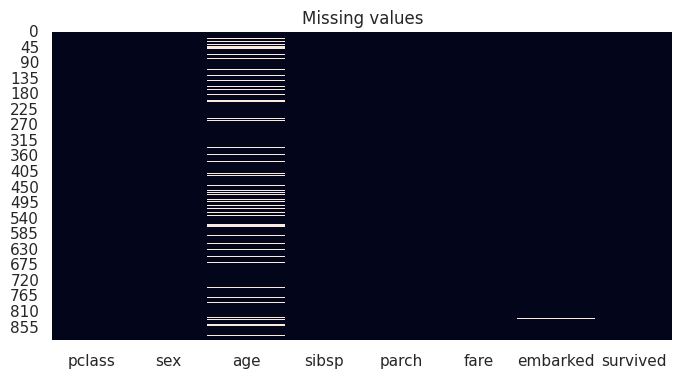

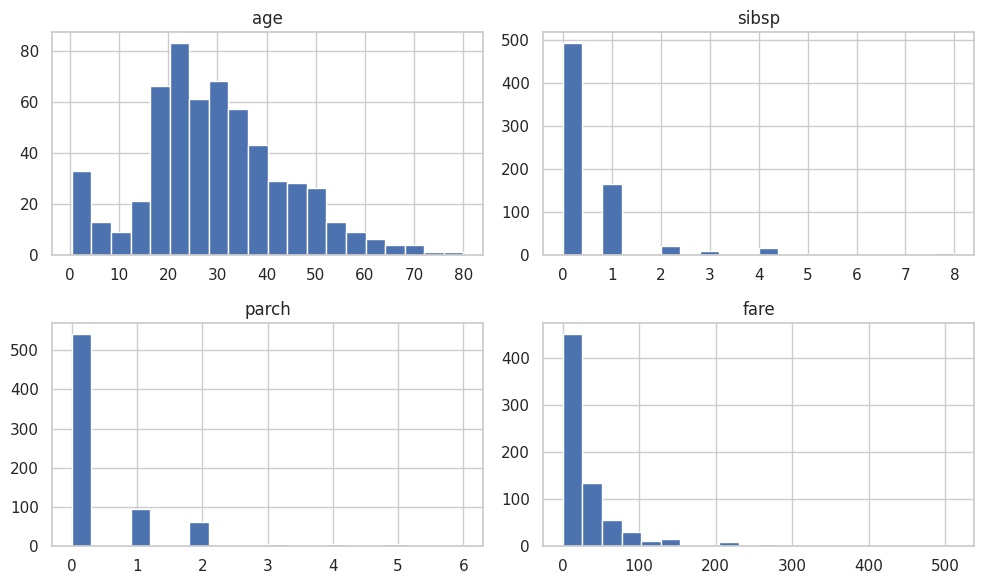

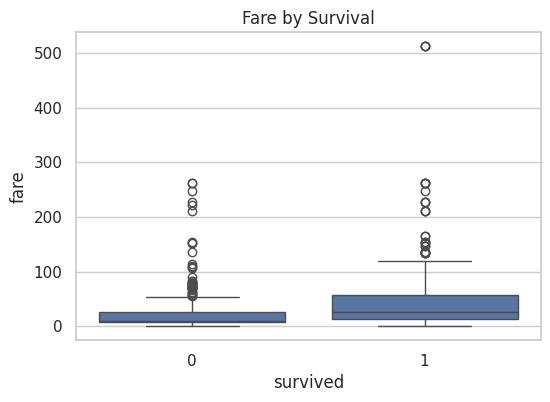

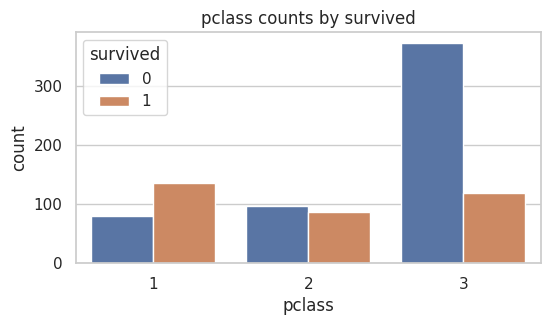

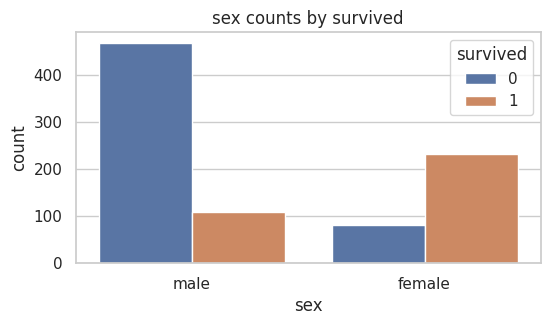

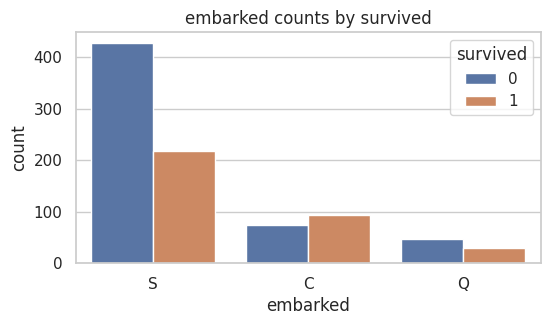

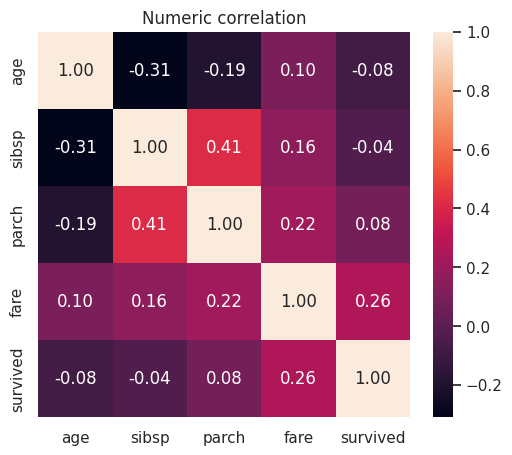

In [5]:
plt.figure(figsize=(8,4))
sns.heatmap(df_model.isnull(), cbar=False)
plt.title('Missing values')
plt.show()


X_train[numeric_features].hist(bins=20, figsize=(10,6))
plt.tight_layout()
plt.show()

if 'survived' in df.columns:
    plt.figure(figsize=(6,4))
    sns.boxplot(x=df_model[TARGET], y=df_model['fare'])
    plt.title('Fare by Survival')
    plt.show()

for col in categorical_features:
    plt.figure(figsize=(6,3))
    sns.countplot(data=df_model, x=col, hue=TARGET)
    plt.title(f'{col} counts by {TARGET}')
    plt.show()


plt.figure(figsize=(6,5))
num_corr = df_model[numeric_features + [TARGET]].corr()
sns.heatmap(num_corr, annot=True, fmt='.2f')
plt.title('Numeric correlation')
plt.show()



Logistic Regression accuracy: 0.8044692737430168

Confusion Matrix:
 [[98 12]
 [23 46]]

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.89      0.85       110
           1       0.79      0.67      0.72        69

    accuracy                           0.80       179
   macro avg       0.80      0.78      0.79       179
weighted avg       0.80      0.80      0.80       179



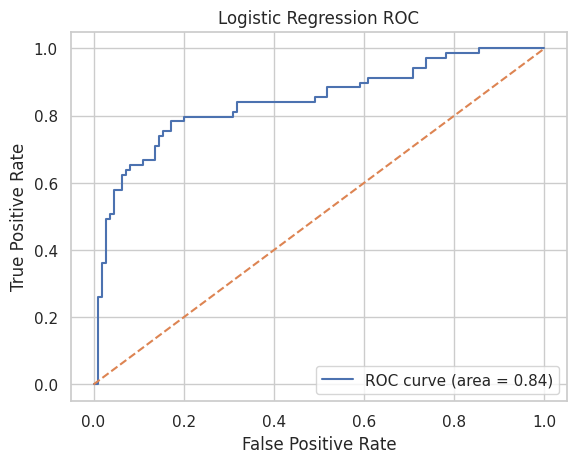

In [6]:
logreg = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

ess = accuracy_score(y_test, y_pred)
print('Logistic Regression accuracy:', ess)
print('\nConfusion Matrix:\n', confusion_matrix(y_test, y_pred))
print('\nClassification Report:\n', classification_report(y_test, y_pred))


if hasattr(logreg, 'predict_proba'):
    y_proba = logreg.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr,tpr)
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0,1],[0,1],'--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Logistic Regression ROC')
    plt.legend(loc='lower right')
    plt.show()

Decision Tree accuracy: 0.7597765363128491

Confusion Matrix:
 [[96 14]
 [29 40]]

Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.87      0.82       110
           1       0.74      0.58      0.65        69

    accuracy                           0.76       179
   macro avg       0.75      0.73      0.73       179
weighted avg       0.76      0.76      0.75       179



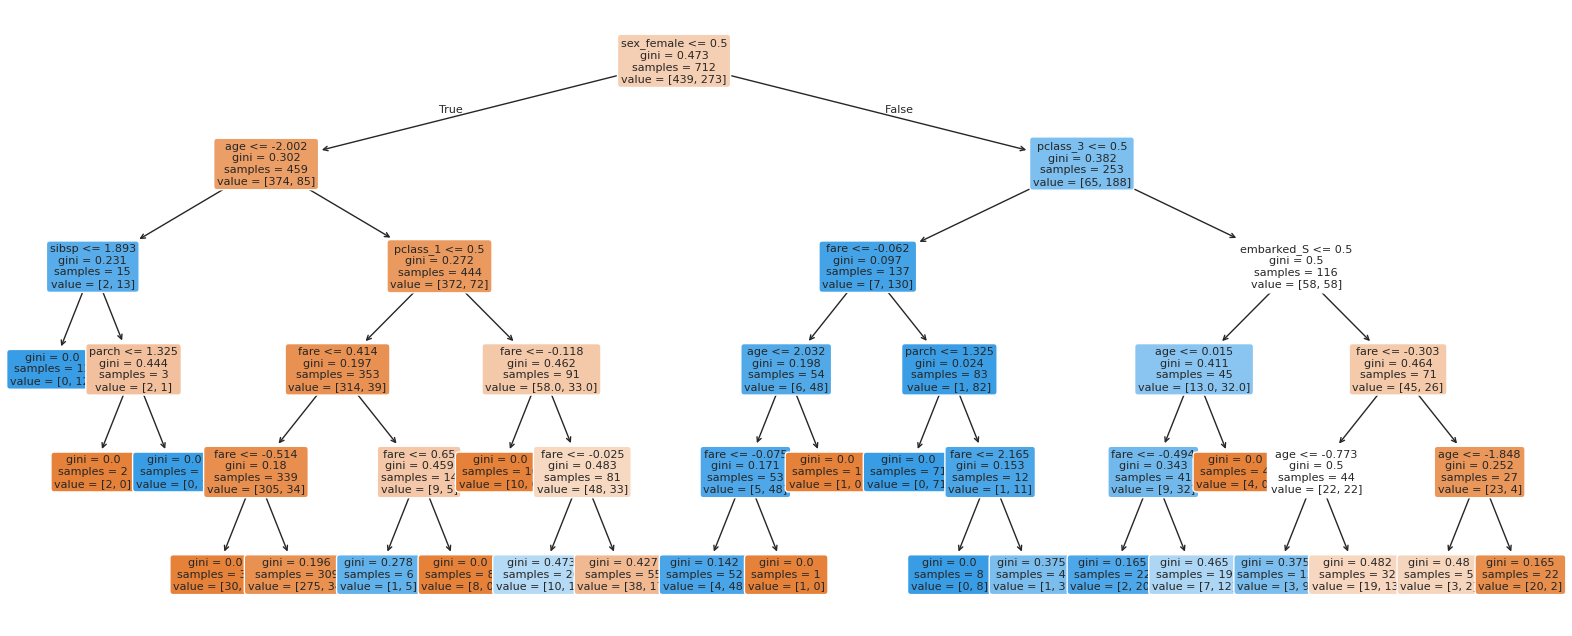

In [7]:
dt = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(max_depth=5, random_state=42))
])

dt.fit(X_train, y_train)

y_pred_dt = dt.predict(X_test)
print('Decision Tree accuracy:', accuracy_score(y_test, y_pred_dt))
print('\nConfusion Matrix:\n', confusion_matrix(y_test, y_pred_dt))
print('\nClassification Report:\n', classification_report(y_test, y_pred_dt))


plt.figure(figsize=(20,8))

onehot_cols = dt.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
feature_names = numeric_features + list(onehot_cols)
plot_tree(dt.named_steps['classifier'], feature_names=feature_names, filled=True, rounded=True, fontsize=8)
plt.show()

In [8]:
import joblib

joblib.dump(logreg, 'logistic_model.joblib')
print('Saved logistic_model.joblib')

Saved logistic_model.joblib
